In [1]:
import pandas as pd
import numpy as np
import logging
import time 
import math
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from scipy.spatial import distance
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm
import pickle

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.default_rng(seed=42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [3]:
df_train = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_train_data_biolincc.pkl")
df_test = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_test_data_biolincc.pkl")
df_train = df_train[['variable_description_1', 'concept_name_1', 'biobert_embedding_1']].drop_duplicates(subset=['variable_description_1', 'concept_name_1']).reset_index(drop=True)
df_train = df_train.reset_index(drop=False)
print(df_train.shape, df_test.shape)

(945, 4) (11890, 10)


In [4]:
labels = df_train.concept_name_1.unique()
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
target_dict = dict(zip(labels, targets))
df_train['target'] = df_train['concept_name_1'].map(target_dict)
df_train['biobert_embedding_2'] = df_train.groupby('target')['biobert_embedding_1'].transform(np.random.permutation)
df_train.head(3)

,index,variable_description_1,concept_name_1,biobert_embedding_1,target,biobert_embedding_2
0,0,MEDICATION J NAME Q13A,INSULIN,"[tensor(0.2296), tensor(-0.4442), tensor(0.231...",42,"[tensor(0.0727), tensor(-0.3114), tensor(0.245..."
1,1,MEDICATION L NAME & CONCENTRATION Q15A,INSULIN,"[tensor(0.0618), tensor(-0.1694), tensor(0.156...",42,"[tensor(0.2078), tensor(-0.2129), tensor(0.214..."
2,2,"Age (years), Exam 3",AGE,"[tensor(0.1348), tensor(-0.0882), tensor(0.275...",1,"[tensor(0.0898), tensor(-0.1406), tensor(0.252..."


In [5]:
df_test.head(3)

,idx,variable_description_1,concept_name_1,study_1,variable_description_2,concept_name_2,study_2,match,biobert_embedding_1,biobert_embedding_2
1,1,Atrial fibrillation,AFIB,ARIC,time to incident af,AFIB,ARIC,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.2017), tensor(-0.1166), tensor(-0.38..."
3,3,Atrial fibrillation,AFIB,ARIC,ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
6,6,Atrial fibrillation,AFIB,ARIC,ECG-ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3071), tensor(-0.1571), tensor(0.261..."


### Dataset Creation

In [6]:
tr_input1 = torch.tensor([x[0].numpy() for x in df_train[['biobert_embedding_1']].to_numpy()])
tr_input2 = torch.tensor([x[0].numpy() for x in df_train[['biobert_embedding_2']].to_numpy()])
tr_targets = torch.tensor([x for x in df_train[['target']].to_numpy()]).to(torch.float32)
tr_idx = torch.tensor([x for x in df_train[['index']].to_numpy()])

te_input1 = torch.tensor([x[0].numpy() for x in df_test[['biobert_embedding_1']].to_numpy()])
te_input2 = torch.tensor([x[0].numpy() for x in df_test[['biobert_embedding_2']].to_numpy()])
te_targets = torch.tensor([x for x in df_test[['match']].to_numpy()]).to(torch.float32)
te_idx = torch.tensor([x for x in df_test[['idx']].to_numpy()])

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  """Entry point for launching an IPython kernel.


In [7]:
batch_size = 50
# verify that the chance of an acutal matching target as a negative sample is low
train_dataset = TensorDataset(tr_idx, tr_input1, tr_input2, tr_targets)
test_dataset = TensorDataset(te_idx, te_input1, te_input2, te_targets)
train_data, val_data = random_split(train_dataset, [750, 195])
train_loader = DataLoader(train_data, batch_size)
val_loader = DataLoader(val_data, batch_size)
test_data, _ = random_split(test_dataset, [11880, 10])
test_loader = DataLoader(test_data, batch_size)

In [8]:
print(tr_idx.shape, tr_input1.shape, tr_input2.shape, tr_targets.shape)

torch.Size([945, 1]) torch.Size([945, 768]) torch.Size([945, 768]) torch.Size([945, 1])


### Model Creation

In [9]:
class SimCLR(pl.LightningModule):

    def __init__(self, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.) - this is the BioBERT encoder
        # self.fcn1 = nn.Sequential(
        #     nn.Linear(768, 256),
        #     nn.ReLU()
        # )
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.fcn = nn.Sequential(
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 56)
        )
    
    def forward(self, inp):
        return self.fcn(inp)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        idx, inp1, inp2, target = batch

        # Encode all inputs
        z1 = self.fcn(inp1)    # Shape: [batch_size, 56]
        z2 = self.fcn(inp2)    # Shape: [batch_size, 56]
        
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(z1.unsqueeze(0), z2.unsqueeze(1), dim=2)    # Shape: [batch_size, batch_size]
        
        # Mask out cosine similarity to itself (unneeded)
        # self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        # cos_sim.masked_fill_(self_mask, -9e15)
        
        # Find positive example -> diagonal of the cos_sim matrix
        pos_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

### Training

In [12]:
CHECKPOINT_PATH = "./runs/CL/"
NUM_WORKERS = os.cpu_count()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

def train_simclr(batch_size, max_epochs=1000, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

Device: cuda:0
Number of workers: 8


In [13]:
simclr_model = train_simclr(batch_size=56,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | fcn  | Sequential | 211 K 
------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.847     Total estimated model params size (MB)


Epoch 0:  79%|███████▉  | 15/19 [00:00<00:00, 92.73it/s, loss=2.45, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 1:  79%|███████▉  | 15/19 [00:00<00:00, 89.21it/s, loss=1.66, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 2:  79%|███████▉  | 15/19 [00:00<00:00, 88.70it/s, loss=1.28, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 3:  79%|███████▉  | 15/19 [00:00<00:00, 89.20it/s, loss=1.07, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 4:  79%|███████▉  | 15/19 [00:00<00:00, 94.94it/s, loss=0.919, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 5:  79%|███████▉  | 15/19 [00:00<00:00, 95.24it/s, loss=0.802, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 6:  79%|███████▉  | 15/19 [00:00<00:00, 95.22it/s, loss=0.717, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 7:  79%|███████▉  | 15/19 [00:00<00:00, 95.27it/s, loss=0.67, v_num=1] 
Validation: 0it [00:00, ?it/s]
Epoch 8:  79%|███████▉  | 15/19 [00:00<00:00, 95.57it/s, loss=0.651, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 9:  79%|███████▉ 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 19/19 [00:00<00:00, 90.26it/s, loss=0.0617, v_num=1]


In [14]:
torch.save(simclr_model.state_dict(), "/mnt/workspace/pratheek/models/saved/model2_biolincc.pth")

### Eval

In [10]:
inf_model = SimCLR(lr=5e-4, temperature=0.07, weight_decay=1e-4)
inf_model.load_state_dict(torch.load('/mnt/workspace/pratheek/models/saved/model2_biolincc.pth'))
if torch.cuda.is_available():
    inf_model = inf_model.to('cuda')
inf_model.eval()

SimCLR(
  (fcn): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=56, bias=True)
  )
)

In [11]:
outputs = []
labels = []
idxs = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output1 = inf_model(inp1)
    output2 = inf_model(inp2)
    
    output = F.cosine_similarity(output1, output2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels.append(label)

idxs = np.concatenate(idxs).ravel()
outputs = np.concatenate(outputs).ravel()
labels = np.concatenate(labels).ravel()

In [12]:
idxs[:10]

array([25972, 14522, 28068, 23957,  4269, 56566, 57157, 18115,  7352,
       37412])

In [13]:
outputs[:10]

array([ 0.09617813,  0.9533832 ,  0.27872637, -0.09644651,  0.6395322 ,
        0.2150836 ,  0.14870813,  0.3642733 ,  0.92068636,  0.40253857],
      dtype=float32)

In [14]:
labels[:10]

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0.], dtype=float32)

In [15]:
with open('./visualization/cl_preds.pkl', 'wb') as wfile:
    pickle.dump(outputs, wfile)
with open('./visualization/cl_gt_labels.pkl', 'wb') as wfile:
    pickle.dump(labels, wfile)

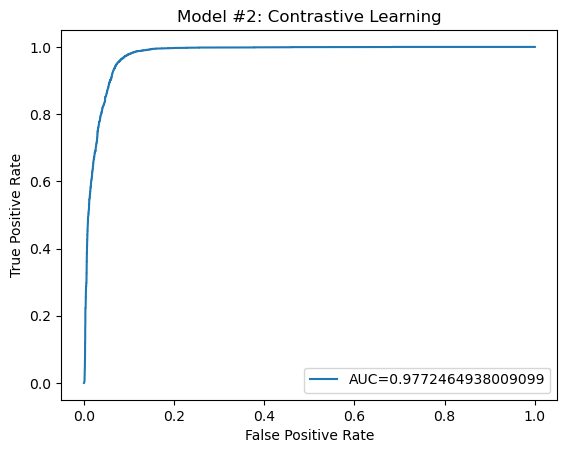

In [16]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(labels, outputs)
auc = metrics.roc_auc_score(labels, outputs)

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Model #2: Contrastive Learning')
plt.legend(loc=4)
plt.show()

In [17]:
inf_df = df_test[df_test['idx'].isin(idxs)]
inf_preds = pd.DataFrame({
    "idx": idxs,
    "match": labels,
    "predict_proba": outputs
})
inf_df = inf_df.merge(inf_preds, on=['idx', 'match'], how='inner')
print(inf_df.shape)
inf_df.head(3)

(11880, 11)


,idx,variable_description_1,concept_name_1,study_1,variable_description_2,concept_name_2,study_2,match,biobert_embedding_1,biobert_embedding_2,predict_proba
0,1,Atrial fibrillation,AFIB,ARIC,time to incident af,AFIB,ARIC,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.2017), tensor(-0.1166), tensor(-0.38...",0.816485
1,3,Atrial fibrillation,AFIB,ARIC,ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.1640), tensor(0.1292), tensor(0.2356...",1.000000
2,6,Atrial fibrillation,AFIB,ARIC,ECG-ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3071), tensor(-0.1571), tensor(0.261...",0.951896


In [18]:
# per-concept AUC
concepts = inf_df.concept_name_1.unique()
mauc_ovr = {}
for concept in concepts:
    print("------------------------")
    
    inf_df_concept = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)]
    print(concept, ": ", inf_df_concept.shape[0])
    
    preds = inf_df_concept.predict_proba.to_list()

    gt_labels = inf_df_concept.match.to_list()
    
    if len(inf_df_concept.match.unique()) == 1:
        print("Only single class present")
        continue
    fpr, tpr, _ = metrics.roc_curve(gt_labels, preds)
    mauc_ovr[concept] = metrics.roc_auc_score(gt_labels, preds)
    print("AUC for", concept, " : ", mauc_ovr[concept])

------------------------
AFIB :  318
AUC for AFIB  :  0.9603355426677713
------------------------
AGE :  321
AUC for AGE  :  1.0
------------------------
ALCOHOL :  250
AUC for ALCOHOL  :  0.9974468085106383
------------------------
ANYCHOLMED :  1180
AUC for ANYCHOLMED  :  0.942267002773897
------------------------
ASPIRIN :  440
AUC for ASPIRIN  :  0.9334784092848609
------------------------
BASE_CVD :  92
AUC for BASE_CVD  :  0.9333333333333332
------------------------
BASE_STROKE :  84
AUC for BASE_STROKE  :  0.978125
------------------------
BG :  136
AUC for BG  :  1.0
------------------------
BMI :  237
AUC for BMI  :  0.9857427055702918
------------------------
CARSTEN :  116
AUC for CARSTEN  :  1.0
------------------------
CENSDAY :  51
AUC for CENSDAY  :  1.0
------------------------
CREAT :  183
AUC for CREAT  :  1.0
------------------------
CURRSMK :  341
AUC for CURRSMK  :  1.0
------------------------
DEATH_IND :  49
AUC for DEATH_IND  :  1.0
------------------------
DIAB

In [19]:
with open('./visualization/cl_mauc_ovr.pkl', 'wb') as wfile:
    pickle.dump(mauc_ovr, wfile)

### Concept Predictor

In [20]:
df_p = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/predictor_data_biolincc.pkl")
df_p = df_p.reset_index(drop=True)
df_p

,variable_description,concept,study,biobert_embedding
0,Atrial fibrillation,AFIB,ARIC,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
1,Incident AF,AFIB,ARIC,"[tensor(-0.0823), tensor(-0.1281), tensor(-0.3..."
2,time to incident af,AFIB,ARIC,"[tensor(0.2017), tensor(-0.1166), tensor(-0.38..."
3,DAYS SINCE EXAM 1,AFIB,ARIC,"[tensor(0.4667), tensor(-0.3528), tensor(-0.15..."
4,ATRIAL FIBRILLATION,AFIB,Framingham,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
...,...,...,...,...
942,TRIG,TRIG,None,"[tensor(0.1032), tensor(0.0132), tensor(0.0905..."
943,VALVDIS,VALVDIS,None,"[tensor(0.4729), tensor(-0.0575), tensor(-0.09..."
944,VEGETABLES,VEGETABLES,None,"[tensor(0.3033), tensor(-0.2493), tensor(-0.44..."
945,VISDAY,VISDAY,None,"[tensor(0.2013), tensor(-0.2242), tensor(-0.23..."


In [21]:
# prepare the predictor dataset
df_p_dict = {}
p_concepts = df_p[df_p['study'] == 'None']['concept'].values
p_concepts_embeds = df_p[df_p['study'] == 'None']['biobert_embedding'].values

In [22]:
p_var_desc = df_p.iloc[0, 0]
p_var_concept = df_p.iloc[0, 1]
p_var_embed = df_p.iloc[0, 3]
p_var_input1 = torch.tensor([p_var_embed.numpy() for i in range(len(p_concepts_embeds))])
p_var_input2 = torch.tensor([p_concept_embed.numpy() for p_concept_embed in p_concepts_embeds])
p_var_target = torch.tensor(pd.Series(p_concepts).str.contains(p_var_concept).astype('int').to_numpy())
df_p_dict[p_var_desc] = (p_var_input1, p_var_input2, p_var_target)

In [23]:
p_pred_score = torch.sigmoid(F.cosine_similarity(inf_model(df_p_dict[p_var_desc][0].to('cuda')), inf_model(df_p_dict[p_var_desc][1].to('cuda')))).cpu().squeeze().detach().numpy()
p_pred_df = pd.DataFrame({
    'concept_name': p_concepts,
    'pred_score': p_pred_score
}).sort_values(by=['pred_score'], ascending=False)
p_pred_df.head(5)

,concept_name,pred_score
0,AFIB,0.700741
36,HXCVD,0.675573
38,HXMI,0.667477
37,HXHRTD,0.667294
35,HRX,0.659599


In [24]:
df_p = df_p.drop_duplicates(subset=['variable_description'])
df_p.shape

(793, 4)

In [25]:
# prepare a custom function for prediction given a sentence
# ensure protobuf = 3.20.x
from biobert_embedding.embedding import BiobertEmbedding
biobert = BiobertEmbedding(model_path='/mnt/workspace/pratheek/packages/biobert/')

class ConceptPredictor:
    def __init__(self, model, concepts, concepts_embeds):
        self.model = model
        self.concepts = concepts
        self.concepts_embeds = concepts_embeds
    
    def predict_concept(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = torch.tensor([sent_embed.numpy() for i in range(len(self.concepts_embeds))])
        input2 = torch.tensor([concept_embed.numpy() for concept_embed in self.concepts_embeds])
        pred_score = torch.sigmoid(F.cosine_similarity(self.model(input1.to('cuda')), self.model(input2.to('cuda')))).cpu().squeeze().detach().numpy()
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'pred_score': pred_score
        }).sort_values(by=['pred_score'], ascending=False)

        return pred_df
    
    def baseline(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = [sent_embed for i in range(len(self.concepts_embeds))]
        input2 = [concept_embed for concept_embed in self.concepts_embeds]
        cos_sim = nn.CosineSimilarity(dim=0)
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'biobert_embedding_1': input1,
            'biobert_embedding_2': input2
        })
        pred_df['cosine_similarity'] = pred_df.apply(lambda x: cos_sim(x.biobert_embedding_1, x.biobert_embedding_2).numpy(), axis=1)
        pred_df = pred_df.drop(columns=['biobert_embedding_1', 'biobert_embedding_2']).sort_values(by=['cosine_similarity'], ascending=False)
        
        return pred_df

2024-04-16 04:43:02.813471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 04:43:03.803232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-16 04:43:03.803353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-16 04:43:03.803366: W tensorflow/compiler/tf2tensorrt/utils/py_u

In [26]:
CPred = ConceptPredictor(inf_model, p_concepts, p_concepts_embeds)

In [27]:
tmp1 = CPred.predict_concept("ECG: RHYTHM")
tmp1

,concept_name,pred_score
38,HXMI,0.675584
35,HRX,0.659947
42,LVH,0.656531
0,AFIB,0.654141
36,HXCVD,0.651637
...,...,...
47,SEX_C,0.543406
53,SYSBP,0.538811
46,RACE_C,0.533165
54,SYSBP1,0.525834


In [28]:
tmp1 = CPred.baseline("ECG: RHYTHM")
tmp1

,concept_name,cosine_similarity
11,CURRSMK,0.85236317
36,HXCVD,0.85200137
27,FASTING_BG,0.8453882
18,DIABP2,0.84490925
26,FASTING_8HR,0.8438038
...,...,...
32,GLUCOSE,0.71754974
1,ALCOHOL,0.71450764
29,FRUITS,0.71361685
59,VEGETABLES,0.6829248


In [29]:
# get the top1 and top5 accuracy
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [30]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  56.4943
top5 accuracy:  76.797


In [31]:
# get the top1 and top5 accuracy (baseline)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.baseline(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [32]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  13.1148
top5 accuracy:  22.8247
